<h1> generate S1,S2 for LZ using fastNEST (LZ-git TDR) </h1>

In [1]:
from __future__ import division
from pyNEST import *
%pylab inline
pylab.rcParams['figure.figsize'] = (10.0, 8.0) # set size of figures"

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


<h3> run the code with a differential energy spectrum as the input. <br/>setup: title to save figure and file path to diff E spectrum , or list of energies </h3>

<h4> Options are file_path=
<ol>
<li>'data/PP_7Be_evt_ton_year_keV_lin_noDiscrim.txt'</li>
<li>'data/B8_DiffRate.txt'</li>
<li>'data/B8_Peter.txt'</li>
<li>'data/ATM_DiffRate.txt'</li>
<li>'data/atm_Peter.txt'</li>
<li>'data/HEP_DiffRate.txt'</li>
<li>'data/hep_Peter.txt'</li>
<li>'data/DSN_DiffRate.txt'</li>
<li>'data/CoherentNuSUM_DiffRate.txt'</li>
<li>'data/dru_er_cryoti_fidvol.txt' </li>
<li>'data/PP_7Be_evt_ton_year_keV_lin_noDiscrim.txt'</li>
<li>'data/PPsolarNu_Peter.txt'</li>
<li>'data/twovBB_evt_ton_year_keV_lin.txt'</li>
<li>'data/Kr85_beta_spectrum_LZ_fid.txt' </li>
<li>'data/Rn222_LZ_fid.txt'</li>
<li>'data/rate_nr_fidvol.txt'</li>
<li>'data/rate_er_fidvol.txt'</li>
</ol>
</h4>

total between 1.00 and 4.40 keV = 0.000260662 [evts/kg/day]
Detector exposure factor = 68.5069


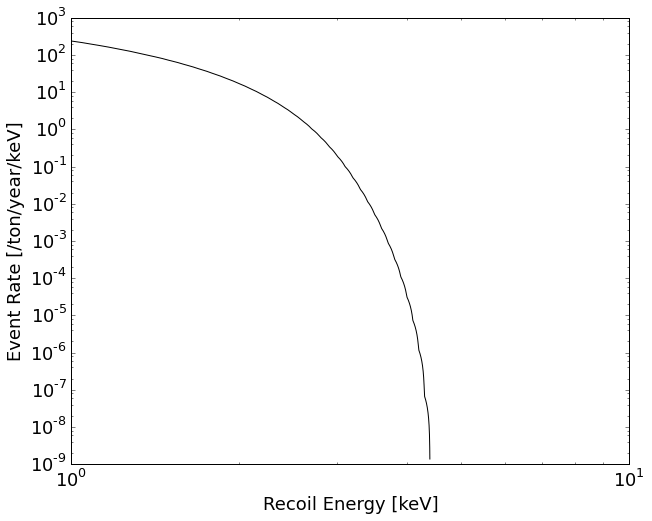

In [2]:
#setup (title to save figure, and file path to diff E spectrum , or list of energies)
title="LUX_B8_fastNEST" 
file_path='data/B8_Peter.txt'
ParticleType='NR' # ER or NR
Det='LZ'
f_drift=700
kg_days=5600*1000
S2raw_min=250

nSim=1e5
##############################################################################
#Get S1 and S2 from differential spectrum
##############################################################################

Nph, Ne, S1, S2, S1c, S2c, Rate_evts_kg_day, Det_exposure_factor = dN2S1S2(file_path=file_path,ParticleType=ParticleType,nSim=nSim,f_drift=f_drift, kg_days=kg_days,Det=Det)
one_Det_bg=int(nSim/Det_exposure_factor) #calc number of events in 1 exposure

# Or use the following to convert energy array into S1,S2 with energy_array=>your energy array
#Nph, Ne, S1, S2 = E2NphNe(Energy =energy_array, ParticleType=ParticleType)


##############################################################################
#Generate Flat ER and NR bands:
##############################################################################
S1_bin_cen_n, mean_S2oS1_n, std_S2oS1_n, S1_bin_cen_e, mean_S2oS1_e, stdev_S2oS1_e, E_bin_cen_e, Eff_e, E_bin_cen_r, Eff_r = genBands(nSim=2e5,Det=Det,S2raw_min=S2raw_min,f_drift=f_drift)


Total Simulated= 1e+05 
Nominal exposoure factor 68.5 
Number below NR mean in WS region= 512 +/- 23
Number above NR mean in WS region= 0 +/- 0
nominal exposure BG in S1 region= 7.474 +/- 0.330
nominal exposure BG in WS region= 7.474 +/- 0.330


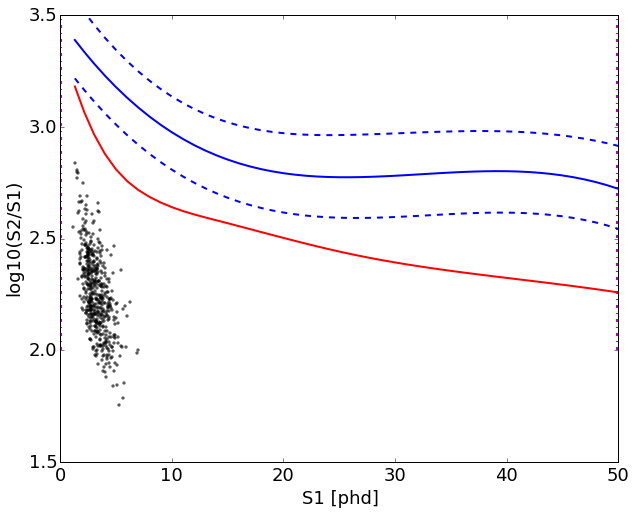

In [5]:
#plot WS region, and Calc expected count in WS region

#search below 50% NR mean and from 3 to 20 PE (1.5 to 6.5 keVee with g1=0.075)
S1_min=0
S1_max=50

#spike count requirement was set in detector parameter. cut on S1>0 

WS_cut=(inrange(S1c,[S1_min,S1_max])) & (S2>=S2raw_min) & (S1c>0)

plt.scatter(S1c[WS_cut],log10(S2c[WS_cut]/S1c[WS_cut]),color='k',s=6,alpha=.5)
plt.xlabel('S1 [phd]')
plt.ylabel('log10(S2/S1)')
plt.rcParams.update({'font.size': 18})
plt.plot([S1_min,S1_min],[2,3.8],'-.m',linewidth=4)
plt.plot([S1_max,S1_max],[2,3.8],'-.m',linewidth=4)

#plot NR mean, with a smooth spline, and calculate number of WS candidates
sNR = ip.UnivariateSpline(S1_bin_cen_n, mean_S2oS1_n,s=.01)
WS_under_NRmean= sum((log10(S2[WS_cut]/S1[WS_cut])<=sNR(S1[WS_cut])) ) 
WS_above_NRmean= sum((log10(S2[WS_cut]/S1[WS_cut])>sNR(S1[WS_cut])) )

plot(S1_bin_cen_n,sNR(S1_bin_cen_n),'-r',linewidth=2)

#plot ER band, with a smooth spline
s = ip.UnivariateSpline(S1_bin_cen_e, mean_S2oS1_e, s=.1)
s_ub = ip.UnivariateSpline(S1_bin_cen_e, mean_S2oS1_e+1.28*stdev_S2oS1_e, s=.1) #1.28 sigma for 10-90% bands
s_lb = ip.UnivariateSpline(S1_bin_cen_e, mean_S2oS1_e-1.28*stdev_S2oS1_e, s=.1)
plot(S1_bin_cen_e,s(S1_bin_cen_e),'-b',linewidth=2)
plot(S1_bin_cen_e,s_ub(S1_bin_cen_e),'--b',linewidth=2)
plot(S1_bin_cen_e,s_lb(S1_bin_cen_e),'--b',linewidth=2)


xlim([0,50])
ylim([1.5,3.5])
savefig('figs/'+title+'.pdf')
savefig('figs/'+title+'.png')


print('Total Simulated= {:.1g} '.format(size(S1)))
print('Nominal exposoure factor {:.1f} '.format(Det_exposure_factor))
print('Number below NR mean in WS region= {:.0f} +/- {:.0f}'.format(WS_under_NRmean, sqrt(WS_under_NRmean)))
print('Number above NR mean in WS region= {:.0f} +/- {:.0f}'.format(WS_above_NRmean, sqrt(WS_above_NRmean)))
print('nominal exposure BG in S1 region= {:.3f} +/- {:.3f}'.format((WS_above_NRmean+WS_under_NRmean)/Det_exposure_factor, sqrt(WS_above_NRmean+WS_under_NRmean)/Det_exposure_factor))
print('nominal exposure BG in WS region= {:.3f} +/- {:.3f}'.format(WS_under_NRmean/Det_exposure_factor, sqrt(WS_under_NRmean)/Det_exposure_factor))